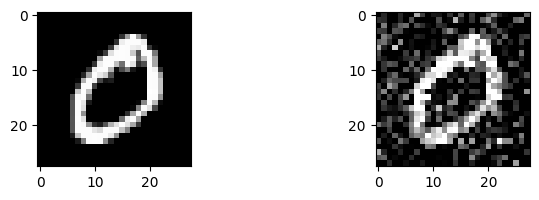

(60000, 2, 28, 28)
1


In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

def expand_dataset(data, noise_factor=0.3):
    expanded_data = []
    for i, [image, label] in enumerate(data):
        noise = np.random.normal(0, noise_factor, image.shape)
        noisy_image = image + noise
        noisy_image = np.clip(noisy_image, 0., 1.)
        expanded_data.append((noisy_image, image))
        if i == 1:
            fig, axes = plt.subplots(1, 2, figsize=(8, 2))
            axes[1].imshow(noisy_image, cmap='gray')
            axes[0].imshow(image, cmap='gray')

            plt.show()
            #plot only one example here
    return np.array(expanded_data)
dataset = expand_dataset(zip(x_train, y_train))

print(dataset.shape)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

dataset = dataset.map(lambda x: (tf.cast(x[0], tf.float32), tf.cast(x[1], tf.float32)))

dataset = dataset.batch(64)

print(1)




In [4]:
from tensorflow.keras import layers, Model

class DigitAutoencoder(tf.keras.Model):
    def __init__(self):
        super(DigitAutoencoder, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=(28, 28, 1)),
            layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
            layers.Conv2D(128, (7, 7), strides=(1, 1), padding='valid', activation='relu'),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(4, activation='relu')
        ])
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(512, activation='relu', input_shape=(None, None, 4)),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Reshape((1, 1, 128)),
            layers.Conv2DTranspose(64, (7, 7), strides=(1, 1), padding='valid', activation='relu'),
            layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu'),
            layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', activation='sigmoid')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate the model
model = DigitAutoencoder()

# Define the input shape
input_shape = (1, 28, 28,1)

# Build the model
model.build(input_shape)

# Display the model summary
model.summary()

# model.encoder.summary()
# model.decoder.summary()

loss_history = []

Model: "digit_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 4)                 577636    
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         577633    
                                                                 
Total params: 1,155,269
Trainable params: 1,155,269
Non-trainable params: 0
_________________________________________________________________


In [116]:
def reset_n_filter(n):
    # resets ns filter in encoder last layer
    last_conv_layer_weights = model.encoder.layers[-1].get_weights()
    print(last_conv_layer_weights[0][:, :, :, n])
    last_conv_layer_weights[0][:, :, :, n] = 0
    model.encoder.layers[-1].set_weights(last_conv_layer_weights)
    
#reset_n_filter(4)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [7]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss=tf.keras.losses.MSE)

history = model.fit(dataset, epochs=10, steps_per_epoch=len(dataset))

#todo epoch history plot

loss_history.extend(history.history['loss'])
# noize in input:  0.0147
# noize in output: 0.0155
# no noize:        0.0141

Epoch 1/10
938/938 [==============================] - 10s 10ms/step - loss: 0.0394
Epoch 2/10
938/938 [==============================] - 9s 9ms/step - loss: 0.0388
Epoch 3/10
938/938 [==============================] - 9s 9ms/step - loss: 0.0383
Epoch 4/10
938/938 [==============================] - 9s 9ms/step - loss: 0.0377
Epoch 5/10
938/938 [==============================] - 9s 9ms/step - loss: 0.0372
Epoch 6/10
938/938 [==============================] - 9s 9ms/step - loss: 0.0367
Epoch 7/10
938/938 [==============================] - 9s 9ms/step - loss: 0.0361
Epoch 8/10
938/938 [==============================] - 9s 9ms/step - loss: 0.0357
Epoch 9/10
938/938 [==============================] - 9s 9ms/step - loss: 0.0353
Epoch 10/10
938/938 [==============================] - 8s 9ms/step - loss: 0.0349


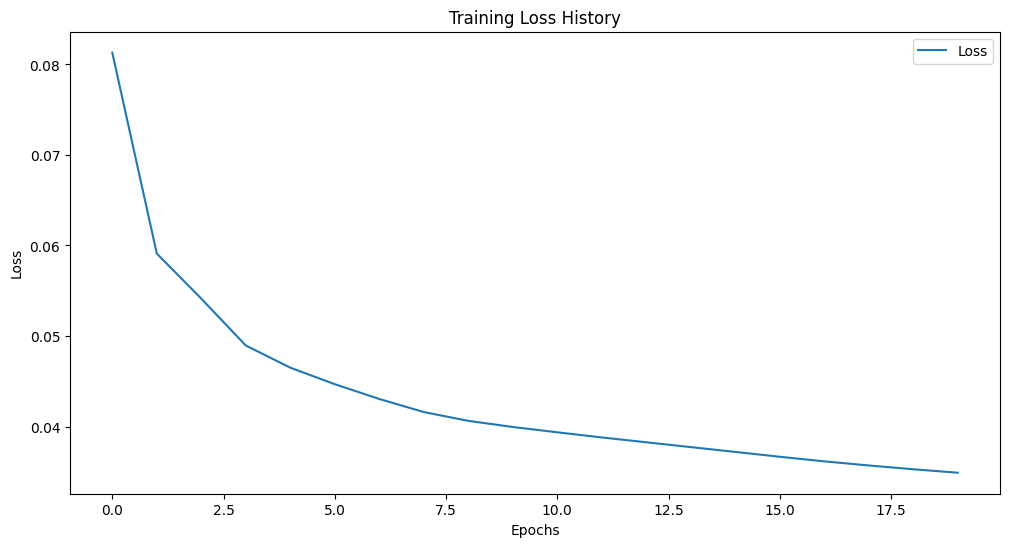

In [8]:
import matplotlib.pyplot as plt

# Построение графика истории потерь
plt.figure(figsize=(12, 6))
plt.plot(loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()


In [21]:

plt.plot(loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.show()

NameError: name 'loss_history' is not defined

1/1 [==============================] - 0s 23ms/step


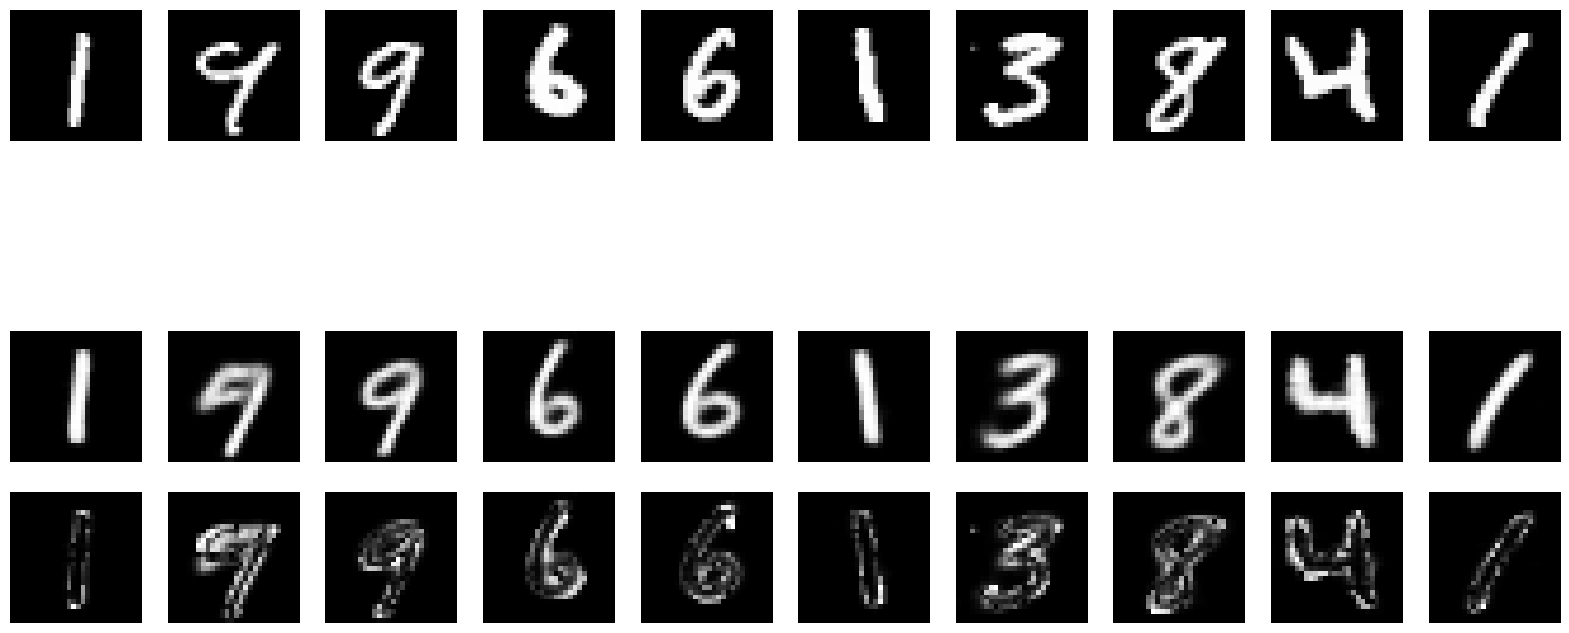

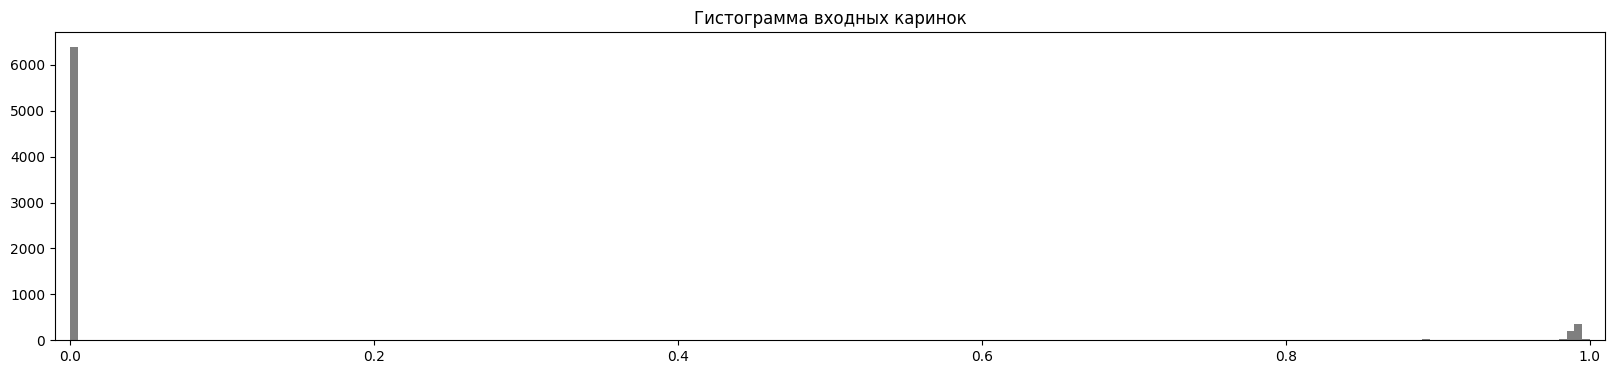

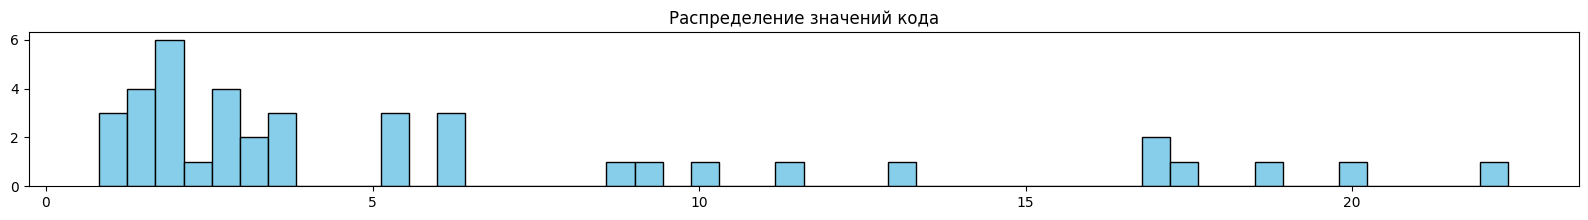

In [51]:
num = 10
images_in, images_out = next(iter(dataset.take(1)))
images = images_out
indices = np.random.choice(len(images), num, replace=False)
images = np.array([images[i] for i in indices])
reconstructed_images = (model.predict(images)) 
codes = model.encoder.predict(images[:num, :])
reconstructed_images  = reconstructed_images.reshape(reconstructed_images.shape[:3])

fig, axes = plt.subplots(4, num, figsize=(20, 8))
for i in range(num):
    axes[0, i].imshow(images[i], cmap='gray')  
    axes[0, i].axis('off')
    try:
        axes[1, i].axis('off')
        axes[1, i].imshow(codes[i][:,:,:3], cmap='gray') 
    except:
        pass
    axes[2, i].imshow(reconstructed_images[i], cmap='gray') 
    axes[2, i].axis('off')
    axes[3, i].imshow(np.abs(reconstructed_images[i]-images[i]), cmap='gray')
    axes[3, i].axis('off')

plt.show()

plt.figure(figsize=(20, 4))
plt.xlim([-0.01, 1.01])
plt.hist(images[:,:,:].reshape(-1), bins=200, color='black', alpha = 0.5)
plt.title('Гистограмма входных каринок')
plt.show()

plt.figure(figsize=(20, 2))
plt.hist(codes.reshape(-1), bins=50, color='skyblue', edgecolor='black')
plt.title('Распределение значений кода')
plt.show()


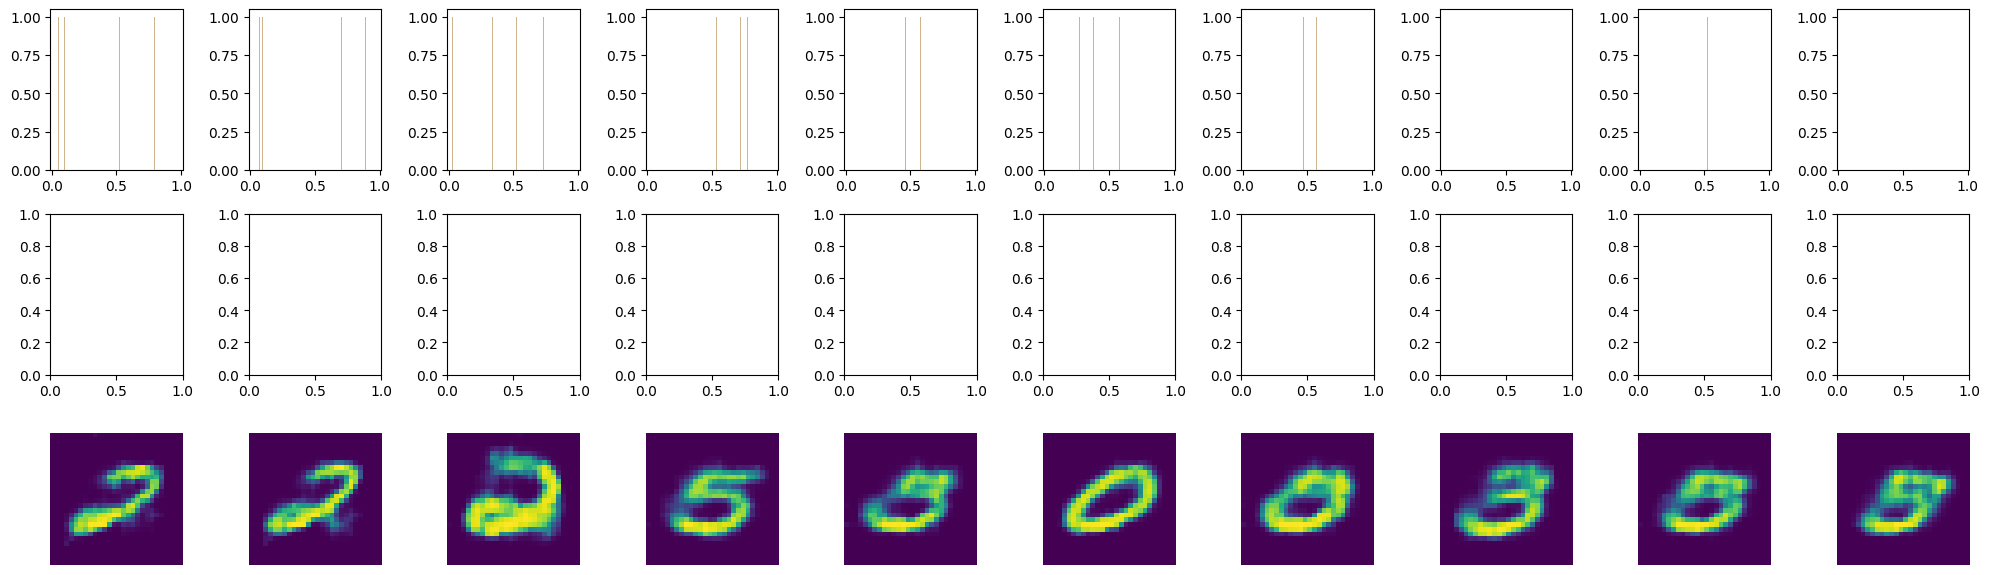

In [52]:
import numpy as np
import matplotlib.pyplot as plt


num = 10


input_shape = model.decoder.input_shape[2:]

def generate_image(i):
    a = i+0.01
    img = np.random.normal(0, 1, input_shape)
    img = img / a
    img = np.clip(img, -1, 1)
    img = img / 2 + 0.5
    img = np.where(img == 0, np.random.uniform(0, 1, img.shape), img)
    img = np.where(img == 1, np.random.uniform(0, 1, img.shape), img)
    return img
random_images = np.zeros((num, *input_shape))
for i in range(num):
    random_images[i] = generate_image(i)

reconstructed_images = model.decoder(random_images)

fig, axes = plt.subplots(3, num, figsize=(20, 6))
for i in range(num):
    axes[0, i].hist(random_images[i].flatten(), bins=100, color='tan')
    axes[0, i].set_xlim([-0.01, 1.01]) 

    #axes[1, i].imshow(random_images[i, :, :, :3])
    #axes[1, i].axis('off')
    
    axes[2, i].imshow(reconstructed_images[i, :, :, :3])
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


60/60 [==============================] - 0s 6ms/step


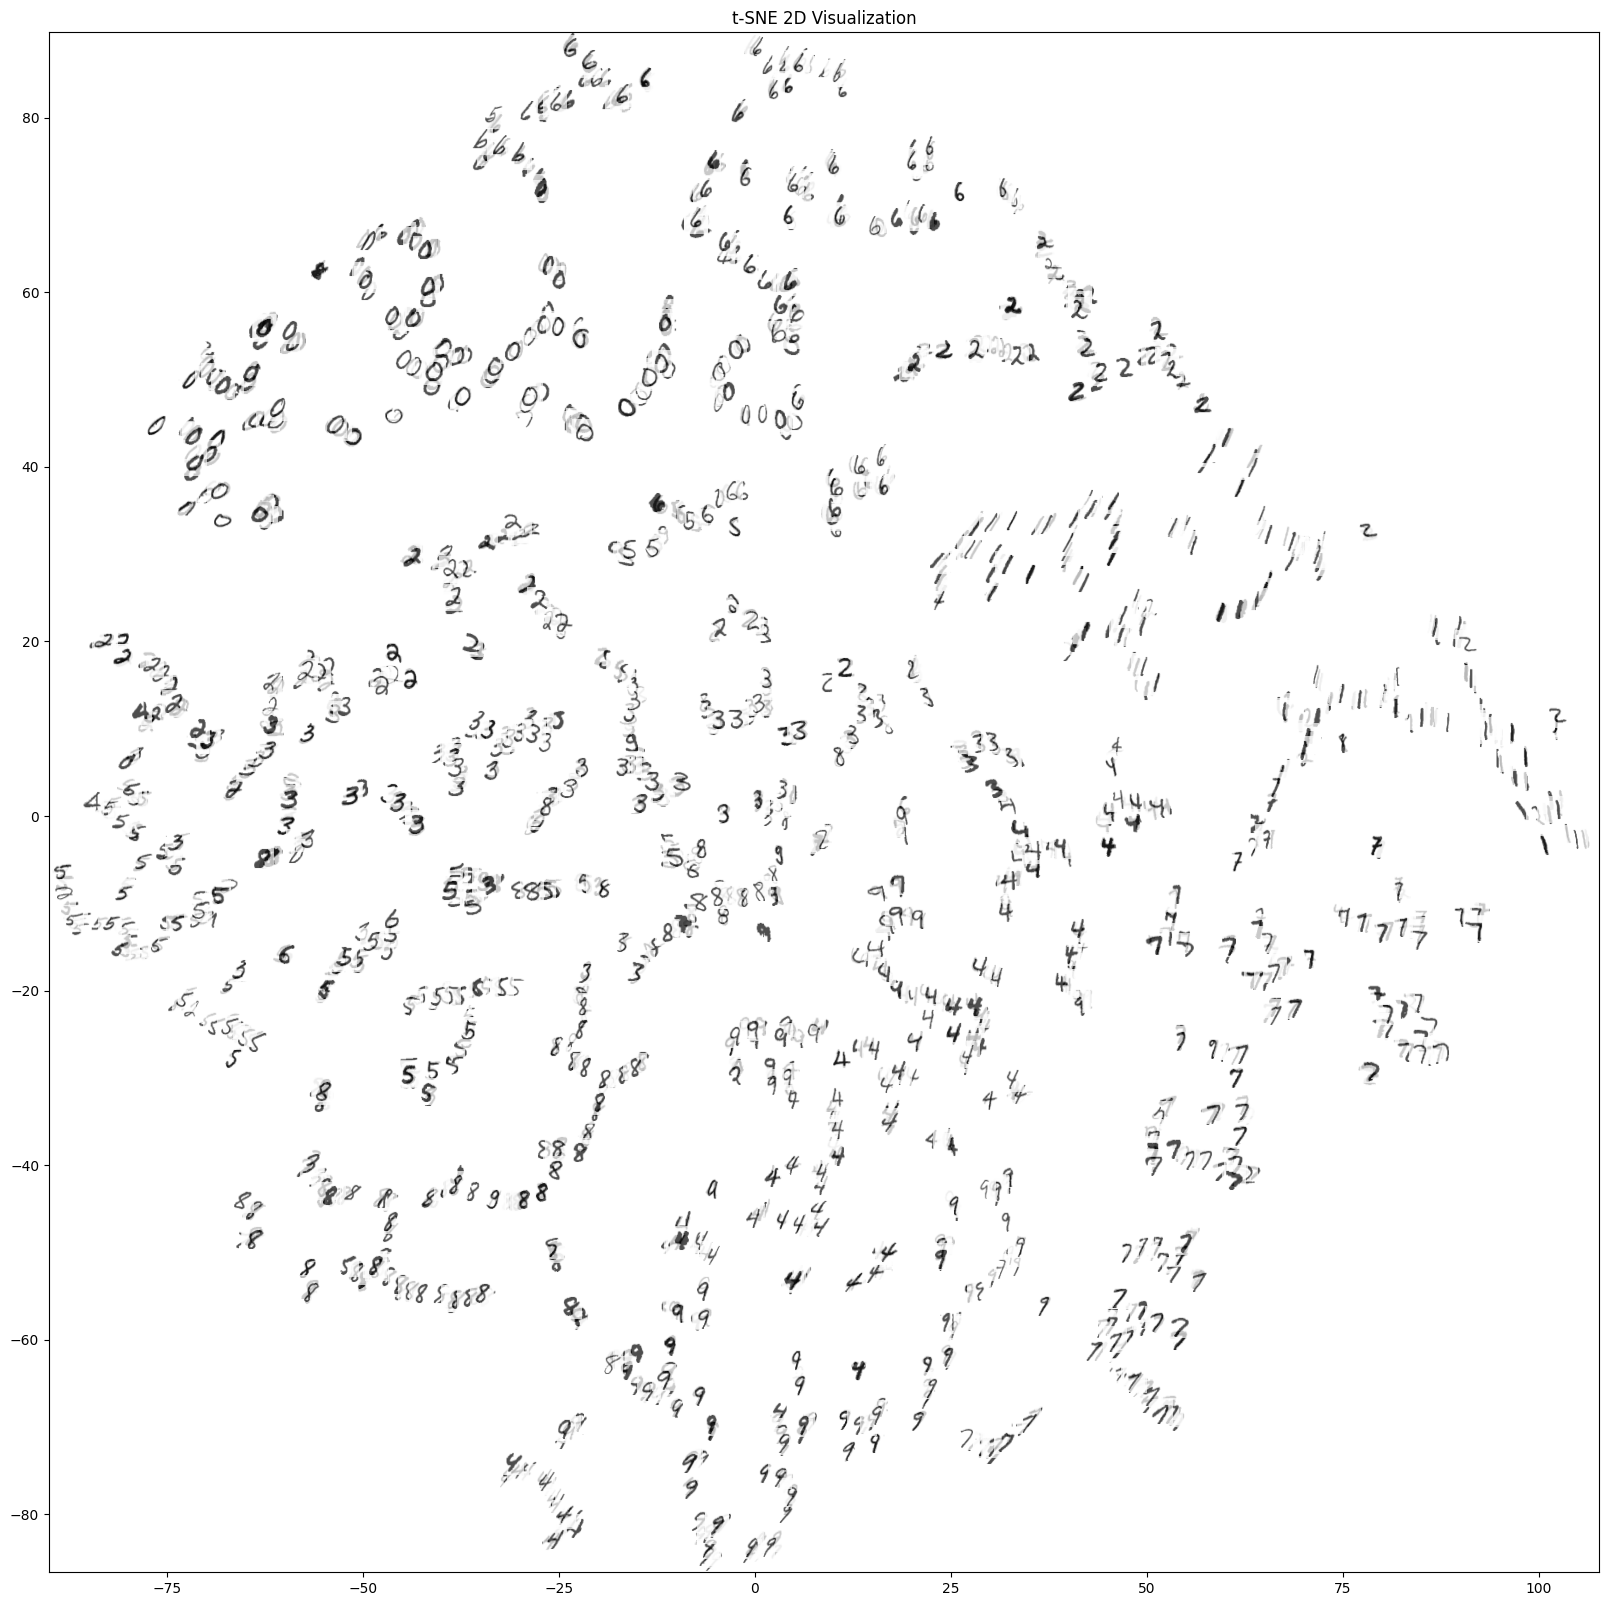

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

all_images = []
n_batches = 30

for i, (images_in, images_out) in enumerate(dataset.take(n_batches)):
    all_images.extend(images_out) 

images = np.array(all_images)
codes = model.encoder.predict(images)
mean_colors = np.mean(images, axis=(1, 2))
codes_2d = codes.reshape(codes.shape[0], -1)
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
reduced_codes = tsne.fit_transform(codes_2d)

fig2d = plt.figure(figsize=(20, 20))
ax2d = fig2d.add_subplot(111)
scatter2d = ax2d.scatter(reduced_codes[:, 0], reduced_codes[:, 1], c=range(len(all_images)), cmap='viridis', s=0)

def display_mini_images(ax, scatter, images, size=(3, 3)):
    for i, (x, y) in enumerate(scatter.get_offsets()):
        ax.imshow(1-images[i], extent=(x, x+size[0], y, y+size[1]), aspect='auto', alpha=0.7, zorder=0, cmap='gray')
        ax.scatter(x, y, c='white', s=0, zorder=1)

display_mini_images(ax2d, scatter2d, images)

ax2d.set_title('t-SNE 2D Visualization')
plt.show()

1/1 [==============================] - 0s 22ms/step


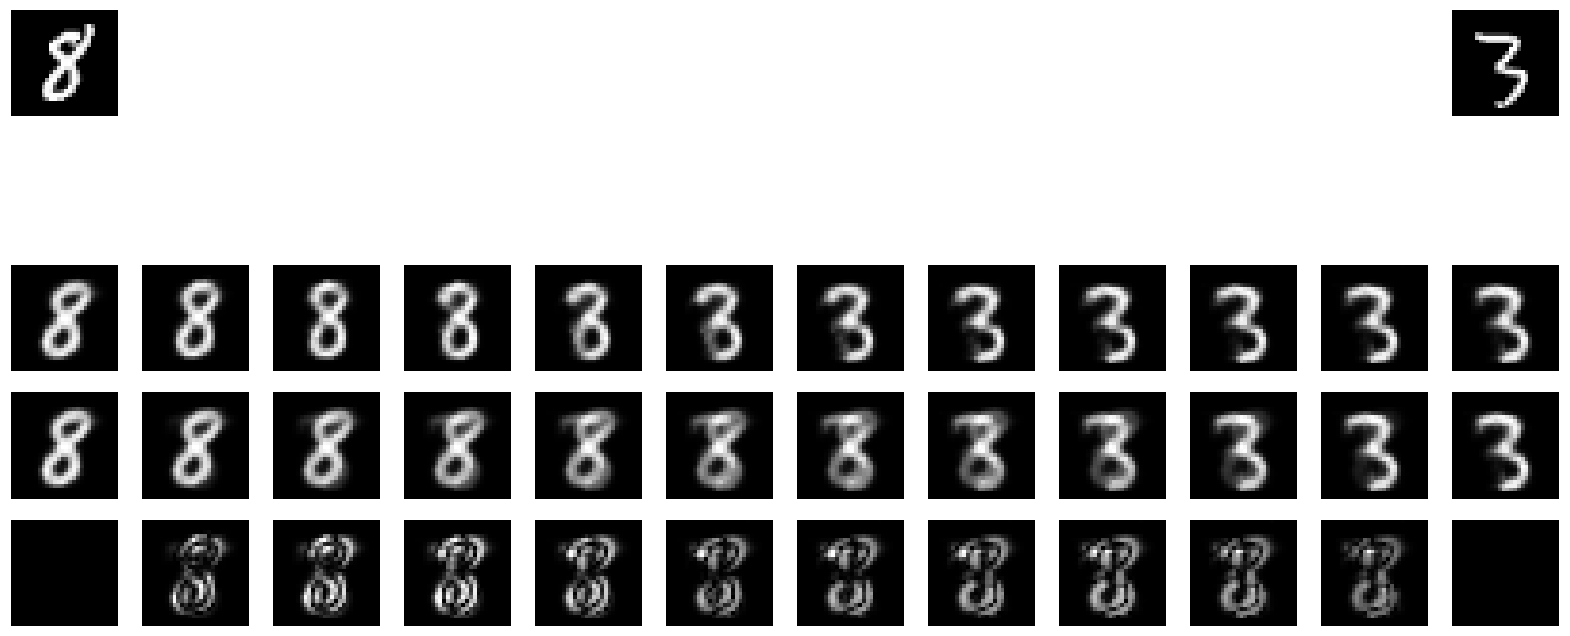

In [57]:
import matplotlib.pyplot as plt

def get_permutated_codes(steps, code_start, code_end):
    codes = []
    for i in range(steps):
        blend = i/(steps-1)
        code = code_start*(1-blend)+ code_end*blend
        codes.append(code)
    return np.array(codes)

def blend_images(blend, image_start, image_end):
    return image_start*(1-blend)+ image_end*blend


steps = 12



images_in, images_out = next(iter(dataset.take(1)))
indices = np.random.choice(len(images_out), 2, replace=False)
images_out = np.array([images_out[i] for i in indices])

image_start = images_out[0]
image_end = images_out[1]

codes = model.encoder.predict(images_out)

code_start = codes[0]
code_end = codes[1]

permutated_codes = get_permutated_codes(steps, code_start, code_end)
reconstructed_images = model.decoder.predict(permutated_codes)

fig, axes = plt.subplots(5, steps, figsize=(20, 8))
axes[0, 0].imshow(image_start, cmap='gray') 
axes[0, steps-1].imshow(image_end, cmap='gray') 

for i in range(steps):
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    #axes[1, i].imshow(permutated_codes[i,:,:,:3]), cmap='gray'  
    axes[2, i].imshow(reconstructed_images[i], cmap='gray') 
    axes[2, i].axis('off')
    blended_image = blend_images(i/(steps-1), reconstructed_images[0], reconstructed_images[-1])
    axes[3, i].imshow(blended_image, cmap='gray') 
    axes[3, i].axis('off')
    axes[4, i].imshow(np.abs(blended_image - reconstructed_images[i]), cmap='gray') 
    axes[4, i].axis('off')


plt.show()


## Save/load model

In [55]:
from tensorflow.keras.models import save_model, load_model

# model.save('checkpoints/lympha0015_3_3_128')
# model.save_weights('checkpoints/lympha0015_3_3_128_weights.h5')

# loaded_model = tf.keras.models.load_model('checkpoints/lympha0015_3_3_128')
# loaded_model.load_weights('checkpoints/lympha0015_3_3_128_weights.h5')